# Sales Forecasting using DeepAR

1. [Introduction](#Introduction)
2. [Prepare Train and Test Datasets](#Prepare-Train-and-Test-Datasets)
3. [Model Training](#Model-Training)
   1. [Define-Hyperparameters](#Define-Hyperparameters)
   2. [Model Fitting](#Model-Fitting)
4. [Deploy Trained Model](#Deploy-Trained-Model)
5. [Consume Deployed Model](#Consume-Deployed-Model)

## Introduction
The [kaggle](https://www.kaggle.com/manjeetsingh/retaildataset) dataset contains historical sales for 45 stores, with each store belonging to a specific type (location and performance) and size. The retailer runs several promotional markdowns throughout the year. These markdowns precede holidays, such as SuperBowl, Labor Day, Thanksgiving, and Christmas.

We will forecast category sales for store 20. Remember that in the previous notebook where we explored sales data, we saved sales of store 20 in a csv file

In [1]:
import os
import shutil
import sagemaker.amazon.common as smac    
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker import get_execution_role
import boto3

In [2]:
#Navidate to deep-ar directory to install the deepar package containing commonly used functions
path = ".."
os.chdir(path)

#install predefined functions
!pip install .

#Navigate to the parent directory to train the DeepAR model
# org_path = ".."
# os.chdir(org_path)

!pwd

Processing /home/ec2-user/SageMaker/DeepAR
  Running setup.py bdist_wheel for deepar ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-zkxguazr/wheels/72/24/18/bb0a1089f91d18faef4459629e814fa0a17bd873e148c04878
Successfully built deepar
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
/home/ec2-user/SageMaker/DeepAR


In [3]:
import deepar as da

## Prepare Train and Test Datasets
The datasets should be in JSON Lines format

In [5]:
train_key      = 'deepar_sales_training.json'
test_key       = 'deepar_sales_test.json'
#Prediction and context length for training the DeepAR model
prediction_length = 9
salesfn = 'data/store20_sales.csv'

salesdf = da.retailsales.prepareSalesData(salesfn)
testSet = da.retailsales.getTestSales(salesdf, test_key)
trainingSet = da.retailsales.getTrainSales(salesdf, train_key, prediction_length)

Note: We have only looked at store 20 sales. However, you can train on all store sales by including store number in the category list - for each series in train and test sets, include "cat": [department number, store number]

### Upload Input data to S3

In [7]:
bucket         = 'ai-in-aws'
prefix         = 'deepar-weekly-sales'

train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')
output_prefix  = '{}/{}'.format(prefix, 'output')

sagemaker_session = sagemaker.Session()

train_path = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path = sagemaker_session.upload_data(test_key, bucket=bucket, key_prefix=test_prefix)

## Model Training

### Configuring the training job

In [8]:
role = get_execution_role()
output_path = r's3://{0}/{1}'.format(bucket, output_prefix) 

container = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

deepAR = sagemaker.estimator.Estimator(container,
                                   role,
                                   train_instance_count=1,
                                   train_instance_type='ml.c4.xlarge',
                                   output_path=output_path,
                                   sagemaker_session=sagemaker_session)

### Define Hyperparameters

In [9]:
hyperparameters = {
    "time_freq": 'W', # weekly series
    "context_length": prediction_length, # how many data points are we going to look at before predicting
    "prediction_length": prediction_length, # number of data points to predict
    "num_cells": "40", # of cells to use in each of the hidden layers
    "num_layers": "2", # of hidden layers
    "likelihood": "gaussian",
    "epochs": "300", # max number of passses over the training data
    "mini_batch_size": "32", # size of the mini batches used during training
    "learning_rate": "0.00001",
    "dropout_rate": "0.05", #for each iteration, a random subset of hidden neurons are not updated
    "early_stopping_patience": "10" # stop if loss hasn't improved in 10 epochs
}

deepAR.set_hyperparameters(**hyperparameters) #** = arbitrary number of arguments to functions

### Model Fitting

In [10]:
data_channels = {"train": train_path, "test": test_path}
deepAR.fit(inputs=data_channels)

2019-09-07 11:52:43 Starting - Starting the training job...
2019-09-07 11:52:45 Starting - Launching requested ML instances......
2019-09-07 11:53:47 Starting - Preparing the instances for training......
2019-09-07 11:54:46 Downloading - Downloading input data...
2019-09-07 11:55:44 Training - Training image download completed. Training in progress.
2019-09-07 11:55:44 Uploading - Uploading generated training model
Arguments: train
[09/07/2019 11:55:30 INFO 140078896834368] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality'

## Deploy Trained Model

In [11]:
deepAR_predictor = deepAR.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

--------------------------------------------------------------------------------------------------!

## Consume Deployed Model

Predicted Sales:  [103340.4375, 100201.9296875, 104847.8828125, 101342.5625, 120300.0234375, 98441.6484375, 103531.828125, 99472.0078125, 107157.6875]
Actual Sales:  [100422.86, 94987.08, 90889.75, 115695.71, 100372.02, 96616.19, 93460.57, 99398.64, 105059.88]


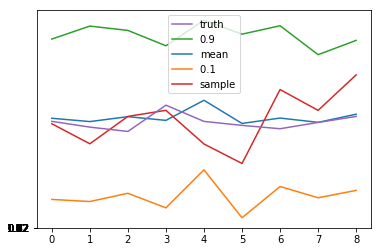

In [15]:
#Predict last 9 weeks of a department and compare to ground truth

deepAR_predictor.content_type = 'application/json'
dept = 90 

prediction_data = da.salesinference.buildInferenceData(dept, trainingSet, testSet)
#print(prediction_data)

result = deepAR_predictor.predict(prediction_data)

y_mean, y_q1, y_q2, y_sample = da.salesinference.getInferenceSeries(result)
print("Predicted Sales: ", y_mean)
print("Actual Sales: ", list(testSet[dept]['Weekly_Sales'][134:]))

da.salesinference.plotResults(prediction_length, result, truth=True, truth_data=testSet[dept]['Weekly_Sales'][134:], truth_label='truth')